In [451]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [452]:
from time import time

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.linear_model import LinearRegression
from scipy import signal
import xrscipy.signal as dsp

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

import gsw

from niwtools.tools import *
from niwtools.qc import *
from epsilon_tools import *

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

purp = pd.read_pickle('../data/purp_colormap.pkl')
# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [520]:
raw = xr.open_dataset('../data/raw_temp.nc')
raw = raw.drop(['pressure'])
raw['eta'] = raw.eta - raw.eta.mean('z')
raw['ddtime'] = raw.dtime

In [521]:
test = raw[['ddtime','eta']].dropna('time', how='all')
test = test.swap_dims({'time':'dtime'})
a = test.rolling(dtime=36, center=True).construct('new')

## Harmonic fit to $\eta$

In [522]:
from scipy.optimize import curve_fit

In [523]:
def phase_cos(t, a, b, c):
    fi = gsw.f(40.3)
    return a*np.cos(fi*t + b) + c

def cosine_fit(tt,yy):
    # those are the windows with time coordinates
    tt = tt[~np.isnan(yy)] 
    yy = yy[~np.isnan(yy)]
    
    if len(yy)>8:
        try:
            popt, _ = curve_fit(phase_cos, tt, yy) # fit over window
        except:
            popt = np.array([np.nan,np.nan,np.nan])
    else:
        popt = np.array([np.nan,np.nan,np.nan])
        
    return popt

def xr_cosine_fit(tt,yy):
    return xr.apply_ufunc(cosine_fit, tt, yy,
                          input_core_dims=[['new'],['new']],
                          output_core_dims=[['popt']],
                          vectorize=True, 
                          output_dtypes=['float64'], 
                          output_sizes={'popt': 3})

In [524]:
results = xr_cosine_fit(a.ddtime, 
                        a.eta)

(-500, 0)

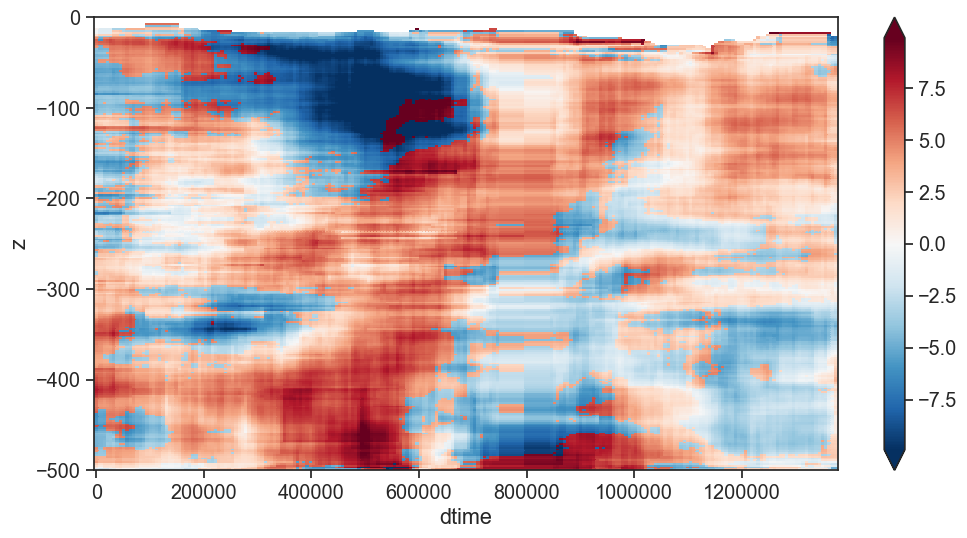

In [525]:
results.isel(popt=0).transpose().plot(robust=True)
plt.ylim(-500,0)

In [526]:
test['amp'] = results.isel(popt=0,drop=True)
test['phase'] = results.isel(popt=1,drop=True)
test['resid'] = results.isel(popt=2,drop=True)
test['fit'] = phase_cos(test.dtime, test.amp, test.phase, test.resid)

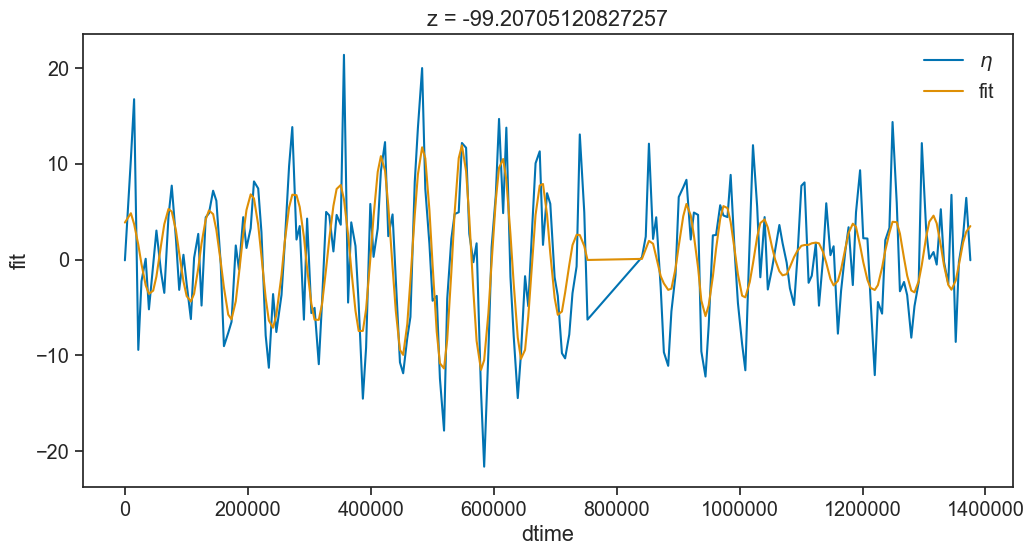

In [527]:
test.eta.isel(z=50).pipe(lambda x: x).plot(label=r'$\eta$')
test.fit.isel(z=50).plot(label=r'fit')
plt.legend()

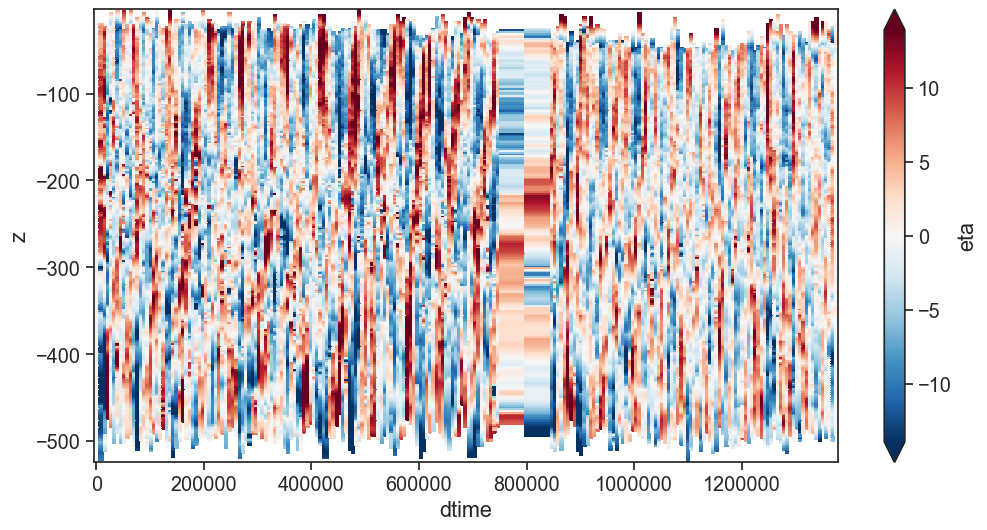

In [528]:
test.eta.dropna(dim='z', how='all').dropna(dim='dtime', how='all').plot(robust=True)

In [529]:
test.fit.isel(backup_time=slice(80,110)).transpose().plot(robust=True, cmap='RdBu_r')
plt.ylim(-500,)

ValueError: dimensions {'backup_time'} do not exist

In [ ]:
# test.pipe(lambda x: x*200).plot()
test.fit.dropna(dim='z', how='all').dropna(dim='dtime', how='all').transpose().plot(robust=True, cmap='RdBu_r')
plt.ylim(-600,)
plt.xlim(100000, 700000)

In [530]:
test['w_fit'] = test.fit.differentiate('dtime')
# test['w_fit'] = (test['w_fit']-test['w_fit'].mean('z'))

In [ ]:
test.w_fit.transpose().plot(robust=True, cmap='RdBu_r', cbar_kwargs={'label':'vertical velocity w [m/s]'}, rasterized=True)
plt.ylim(-500,0)

plt.savefig('../figures/vertical_velocity.pdf')

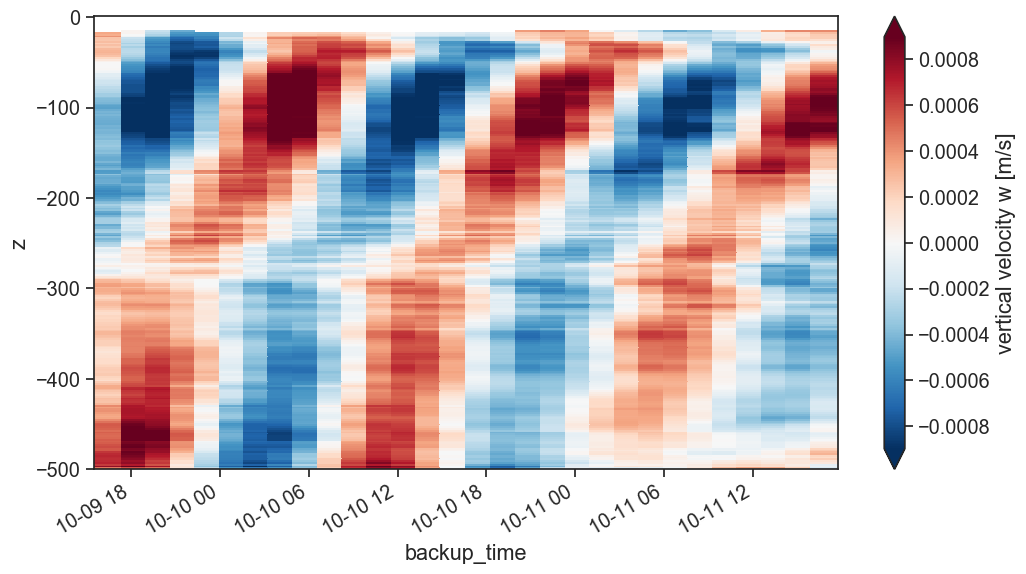

In [519]:
test.w_fit.transpose().isel(backup_time=slice(80,110)).plot(robust=True, cmap='RdBu_r', cbar_kwargs={'label':'vertical velocity w [m/s]'}, rasterized=True)
plt.ylim(-500,)

plt.savefig('../figures/vertical_velocity_zoom.pdf')

## Find b'

In [531]:
test['n2'] = raw.n2

In [532]:
test['b_prime'] = test.n2.mean('time')*test.fit.rolling(dtime=18).mean()
test['b_prime'] = test.b_prime - test.b_prime.mean('dtime')

(-200, 0)

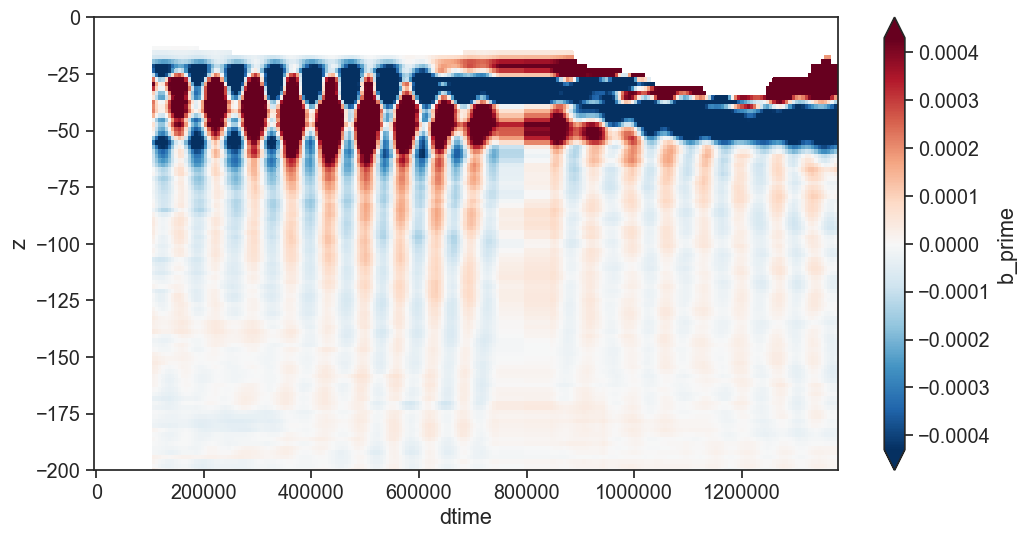

In [533]:
test.b_prime.plot(robust=True, cmap='RdBu_r')
plt.ylim(-200,0)

## Compute p'

$
b' = - N^2\eta \\
p'(z) = \int_z^0 b'dz' - \frac{1}{H}\int_{-H}^0  \int_{z}^0 b'dz'dz
$

In [534]:
tliste=[]
for ti, t in enumerate(raw.time):
    temp = test.isel(dtime=ti)
    
    liste=[]
    for zi, z in enumerate( temp.z):
        if temp.b_prime.isel(z=zi).notnull().any():
            term_a = integral( temp.b_prime, z, 0)
            term_a['z'] = z
            liste.append(term_a)
        else:
            liste.append( np.nan)

    cleanedList = [x for x in liste if type(x)!=float]
    
    if cleanedList:
        new = xr.concat(cleanedList, dim='z')
#         new = new - new.integrate('z')/new.z.max() 

        tliste.append(new)
    
pprime = xr.concat(tliste, dim='dtime')

In [535]:
tliste=[]
for ti, t in enumerate(pprime.dtime):
    temp = pprime.isel(dtime=ti)
    term_b = -integral( temp, temp.z.min(), 0)/ temp.z.min()
    tliste.append(term_b)
    
pprime_b = xr.concat(tliste, dim='dtime')

In [536]:
prime0 = pprime - pprime_b

(-200, 0)

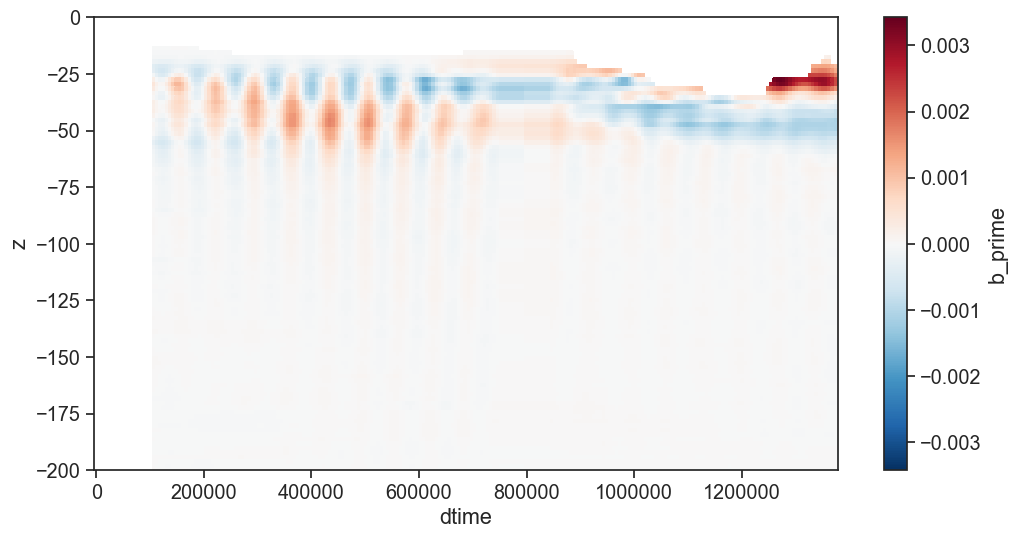

In [537]:
test.b_prime.plot()
plt.ylim(-200,0)

(-200, 0)

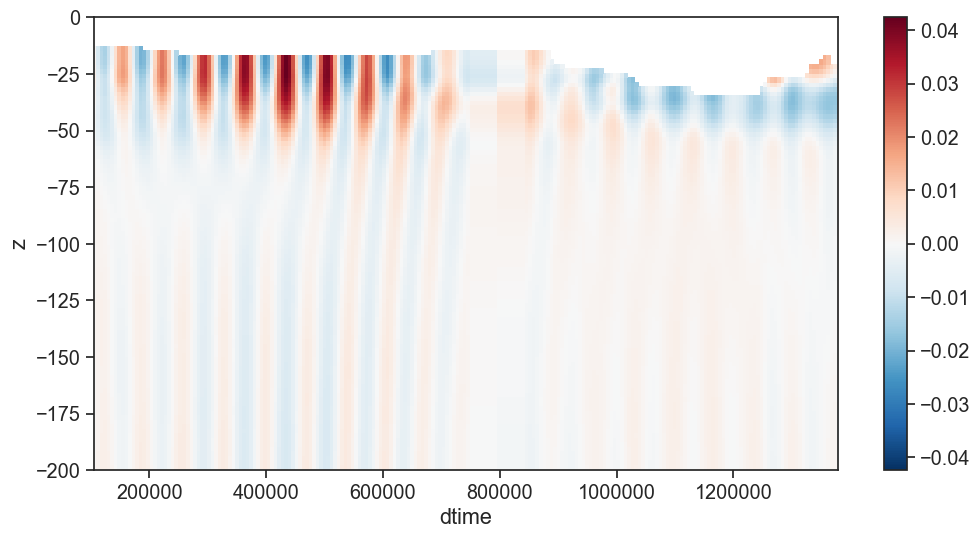

In [538]:
prime0.transpose().plot()
plt.ylim(-200,0)

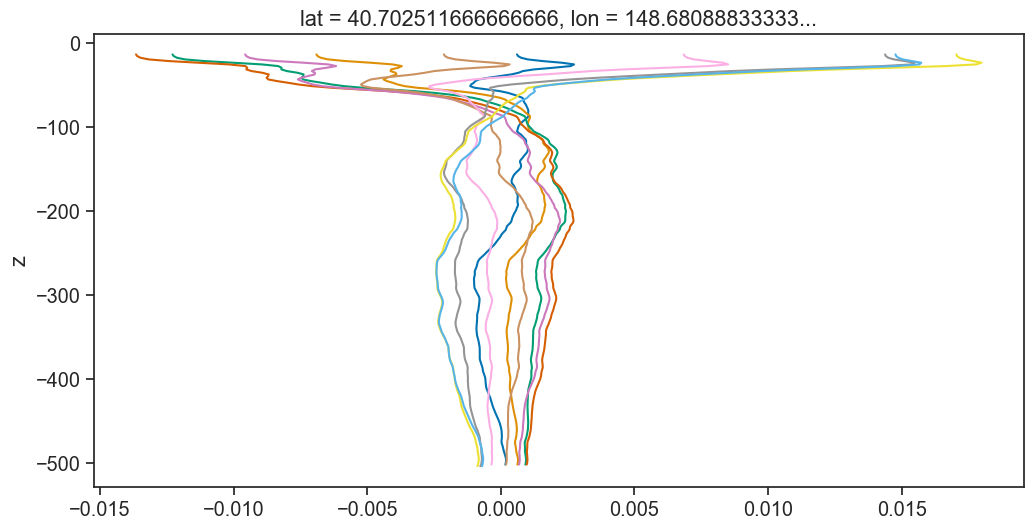

In [539]:
for i in range(10):
    prime0.isel(dtime=i).plot(y='z')

### Compute u'p'

Careful with the dimensions, make a copy first!

In [842]:
test['w_fit'] = test.w_fit.swap_dims({'backup_time':'dtime'})

In [829]:
test['uNI'] = raw.uNI.swap_dims({'time':'dtime'}).transpose()
test['vNI'] = raw.vNI.swap_dims({'time':'dtime'}).transpose()
test['pprime'] = prime0

In [846]:
test['up'] = ((test.uNI-test.uNI.mean('dtime')-test.uNI.mean('z'))*test.pprime).transpose()
test['vp'] = ((test.vNI-test.vNI.mean('dtime')-test.uNI.mean('z'))*test.pprime).transpose()
test['wp'] = (test.w_fit*test.pprime).transpose()

In [849]:
test.to_netcdf('../data/backup_efluxes.nc')

In [850]:
test['backup_time'] = ('dtime', test.time)

In [851]:
test = test.swap_dims({'dtime':'backup_time'})

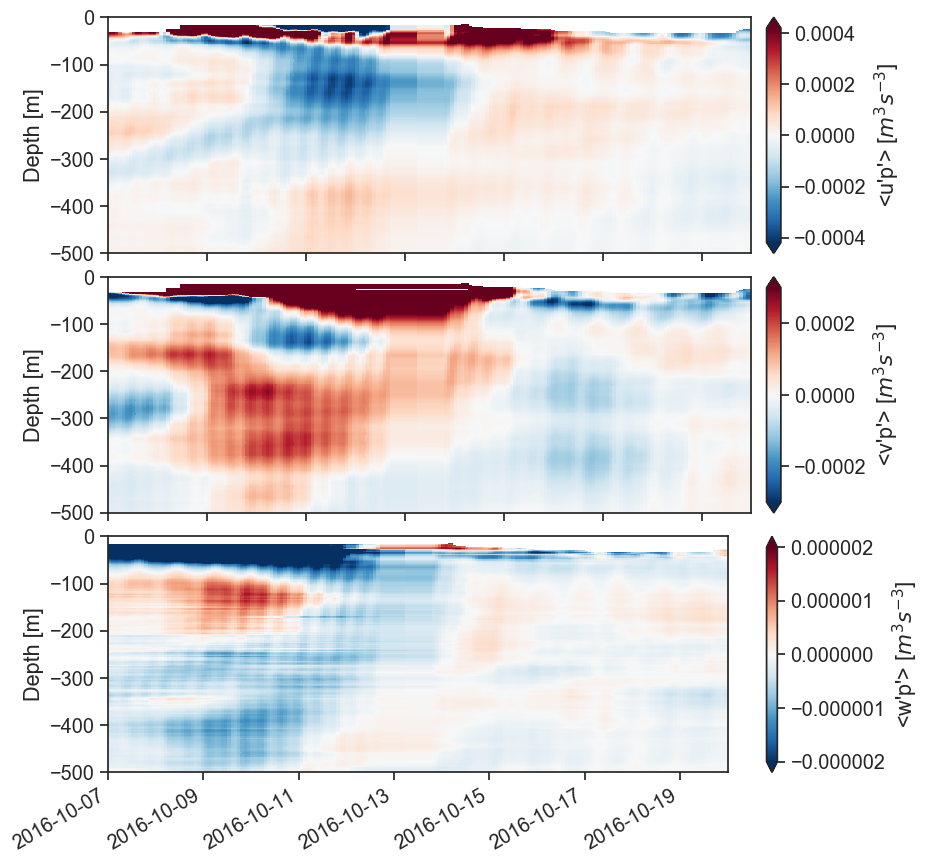

In [852]:
fig, ax = plt.subplots(3,1, figsize=(10,10), sharex=True)

test.up.rolling(backup_time=19).mean().plot(robust=True,
                    cbar_kwargs={'label':"<u'p'> [$m^3 s^{-3}$]",'pad':0.02,'aspect':15}, ax=ax[0], rasterized=True)
ax[0].set_xlabel(None)
ax[0].set_ylim(-500,0)
ax[0].set_xlim('2016-10-7','2016-10-20')
ax[0].set_ylabel('Depth [m]');

test.vp.rolling(backup_time=19).mean().plot(vmin=-0.0003, vmax=0.0003,
                    cbar_kwargs={'label':"<v'p'> [$m^3 s^{-3}$]",'pad':0.02,'aspect':15}, cmap='RdBu_r', ax=ax[1], rasterized=True)
ax[1].set_xlabel(None)
ax[1].set_ylim(-500,0)
ax[1].set_xlim('2016-10-7','2016-10-20')
ax[1].set_ylabel('Depth [m]');

test.wp.rolling(backup_time=19).mean().plot(
                    cbar_kwargs={'label':r"<w'p'> [$m^3 s^{-3}$]"}, vmin=-2e-6, vmax=2e-6, cmap='RdBu_r', ax=ax[2], rasterized=True)

ax[2].set_xlabel(None);
ax[2].set_ylabel('Depth [m]');
ax[2].set_ylim(-500,0)
ax[2].set_xlim('2016-10-7','2016-10-20')

plt.subplots_adjust(hspace=0.1)

# plt.savefig('../figures/energy_fluxes.pdf')

# PLOT map with fluxes

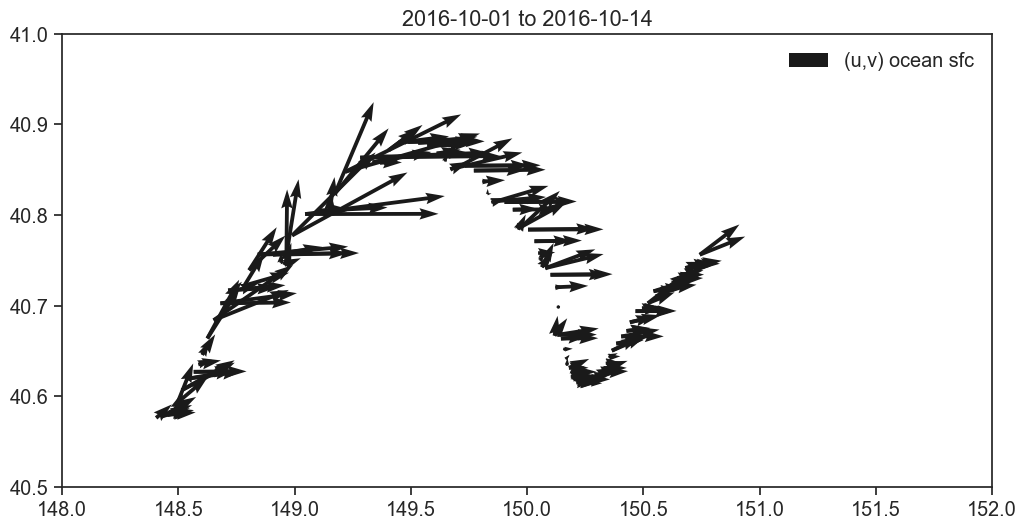

In [853]:
ang = np.arctan2(raw.v_surf,raw.u_surf)
plt.quiver(raw.lon,raw.lat, raw.u_surf, raw.v_surf, label='(u,v) ocean sfc')
# plt.plot(subset.lon.isel(time=20),subset.lat.isel(time=20), marker='o', markersize=10)
# plt.quiver(subset.lon,subset.lat, -subset.tx, -subset.ty, color='green', alpha=0.2, label=r'(-$\tau_x$,-$\tau_y$)')
# plt.quiver(subset.lon,subset.lat, subset.tx, subset.ty, color='red', alpha=0.2, label=r'($\tau_x$,$\tau_y$)')

# temp = cfs.sel(time=slice('2016-10-01','2016-10-21'))
# plt.quiver(temp.lon,temp.lat, temp.tx, temp.ty)

plt.ylim(40.5,41)
plt.xlim(148,152)
plt.title('2016-10-01 to 2016-10-14')
plt.legend()

plt.savefig('../figures/surface_currents.pdf')

In [854]:
test['mld'] = ('backup_time', raw.mld)

In [855]:
test['usurf'] = ('backup_time', raw.u_surf)
test['vsurf'] = ('backup_time', raw.v_surf)

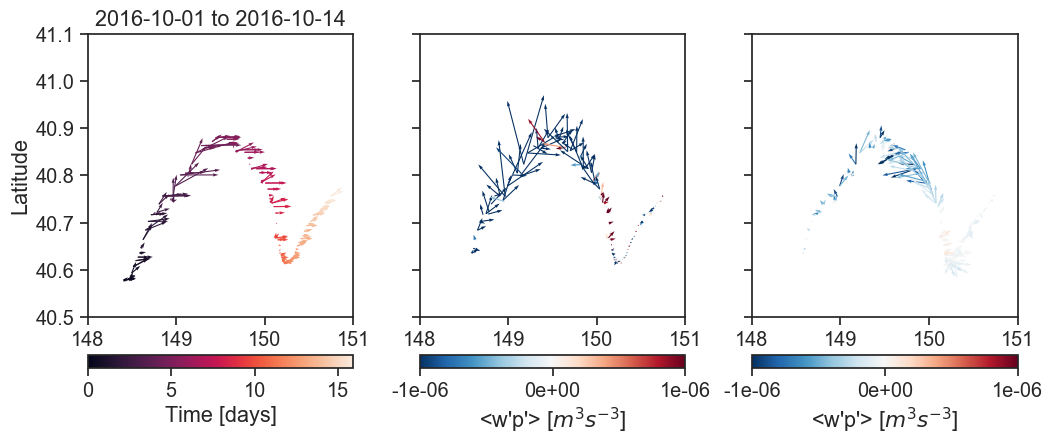

In [857]:
fig, ax = plt.subplots(1,3, figsize=(12,5), sharey=True)


h = ax[0].quiver(test.lon,test.lat, test.usurf, test.vsurf,
           test.dtime/86400, label='(u,v) ocean sfc')

ax[0].set_ylim(40.5,41)
ax[0].set_xlim(148,151)
ax[0].set_title('2016-10-01 to 2016-10-14')
ax[0].set_ylabel('Latitude')
# ax[0].set_xlabel('Longitude')
plt.colorbar(h, ax=ax[0],orientation='horizontal', pad=0.1, label=r"Time [days]")

h = ax[1].quiver(test.lon,test.lat, test.up.where(test.z>test.mld).mean('z'), test.vp.where(test.z>test.mld).mean('z'),
           test.wp.where(test.z>test.mld).mean('z'), label='(u,v) ocean sfc', cmap='RdBu_r', clim=(-1e-6,1e-6))

ax[1].set_ylim(40.5,41.1)
ax[1].set_xlim(148,151)
# ax[1].set_xlabel('Longitude')
# ax[1].set_title('2016-10-01 to 2016-10-14')
# ax[1].set_ylabel('Latitude')
cbar= plt.colorbar(h, ax=ax[1],orientation='horizontal', pad=0.1, label=r"<w'p'> [$m^3 s^{-3}$]",
                  ticks=[-1e-6,0,1e-6], format='%1.0e')

h = ax[2].quiver(test.lon,test.lat, test.up.where( (test.z<-50) & (test.z>-200)).mean('z'), 
           test.vp.where( (test.z<-50) & (test.z>-200)).mean('z'),
           test.wp.where(test.z<test.mld).mean('z'), label='(u,v) ocean sfc', cmap='RdBu_r', clim=(-1e-6,1e-6))

ax[2].set_ylim(40.5,41.1)
ax[2].set_xlim(148,151)
# ax[2].set_title('2016-10-01 to 2016-10-14')
# ax[2].set_xlabel('Longitude')
# ax[2].set_ylabel('Latitude')
plt.colorbar(h, ax=ax[2],orientation='horizontal', pad=0.1, label=r"<w'p'> [$m^3 s^{-3}$]",
             ticks=[-1e-6,0,1e-6], format='%1.0e')

plt.subplots_adjust(wspace=0.25, hspace=0.1)
plt.savefig('../figures/surface_fluxes.currents.pdf')

## Spectra of p'

In [146]:
def compute_spectra_zmean(raw,array):
    raw['dtime'] = ('time', np.array( (raw.time - raw.time.isel(time=0)).values*1e-9, dtype=float))
    raw = raw.swap_dims({'time':'dtime'})
    return dsp.spectrogram(raw[array].dropna('z', how='all').mean('z'), dim='dtime',
                           fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )

def compute_spectra_resid(raw,array):
    raw['dtime'] = ('time', np.array( (raw.time - raw.time.isel(time=0)).values*1e-9, dtype=float))
    raw = raw.swap_dims({'time':'dtime'})
    return dsp.spectrogram(raw[array].dropna('z', how='all')-raw[array].dropna('z', how='all').mean('z'), dim='dtime',
                           fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )

In [147]:
raw['pprime'] = pprime

In [148]:
S_pprime = compute_spectra(raw, 'pprime').mean('dtime')
S_pprime_zmean = compute_spectra_zmean(raw, 'pprime').mean('dtime')
S_pprime_resid = compute_spectra_resid(raw, 'pprime').mean('dtime')

/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  """
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Frequency [cpd]')

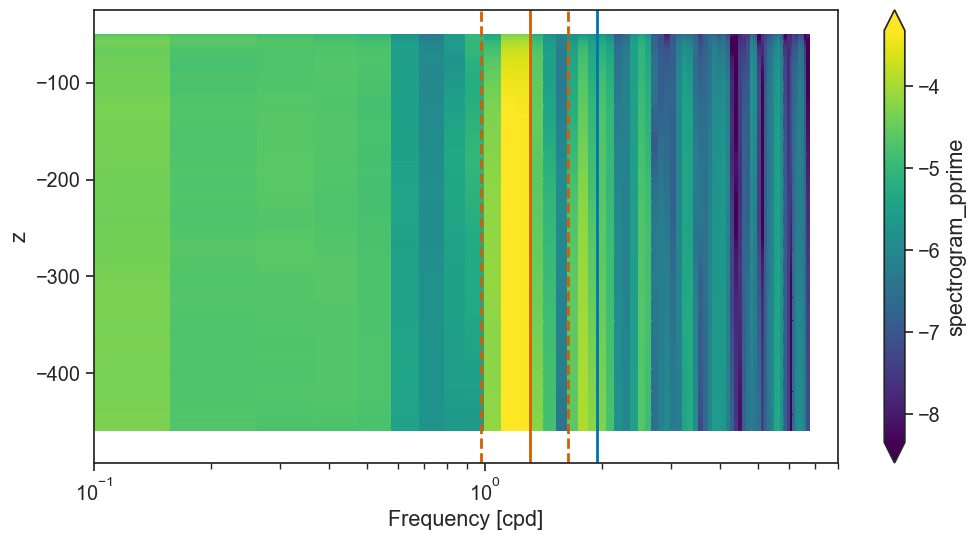

In [149]:
S_pprime.transpose().pipe(np.log10).plot(cmap='viridis', robust=True)
# ax[0].set_ylim(-400,-30)
plt.xlim(1e-1,8e0)
plt.xscale('log')

latmean = 40.7

m2freq = 24/(12+25/60)
plt.axvline(m2freq, lw=2, color='b')
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')

plt.xlabel('Frequency [cpd]')

Text(0.5, 0, 'Frequency [cpd]')

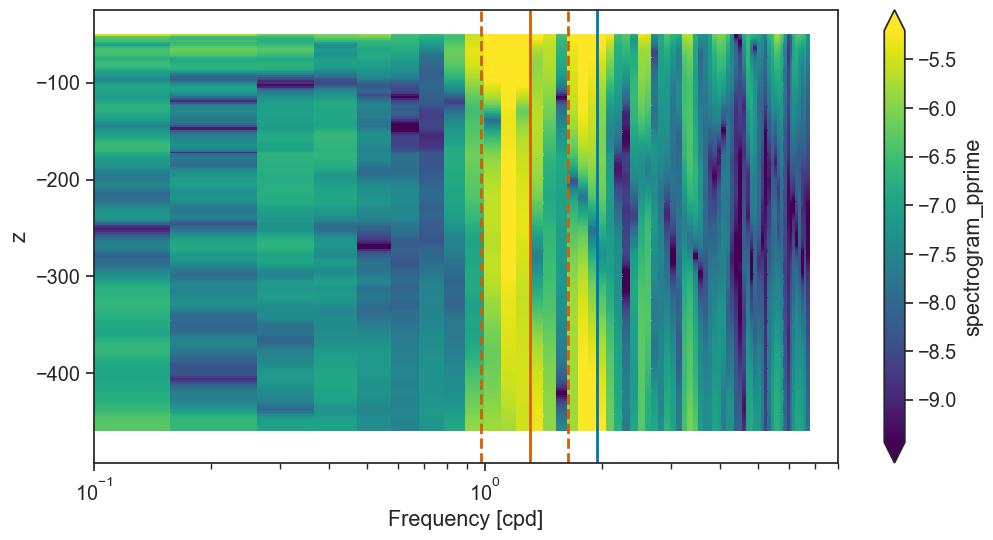

In [150]:
S_pprime_resid.transpose().pipe(np.log10).plot(cmap='viridis', robust=True)
# ax[0].set_ylim(-400,-30)
plt.xlim(1e-1,8e0)
plt.xscale('log')

latmean = 40.7

m2freq = 24/(12+25/60)
plt.axvline(m2freq, lw=2, color='b')
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')

plt.xlabel('Frequency [cpd]')

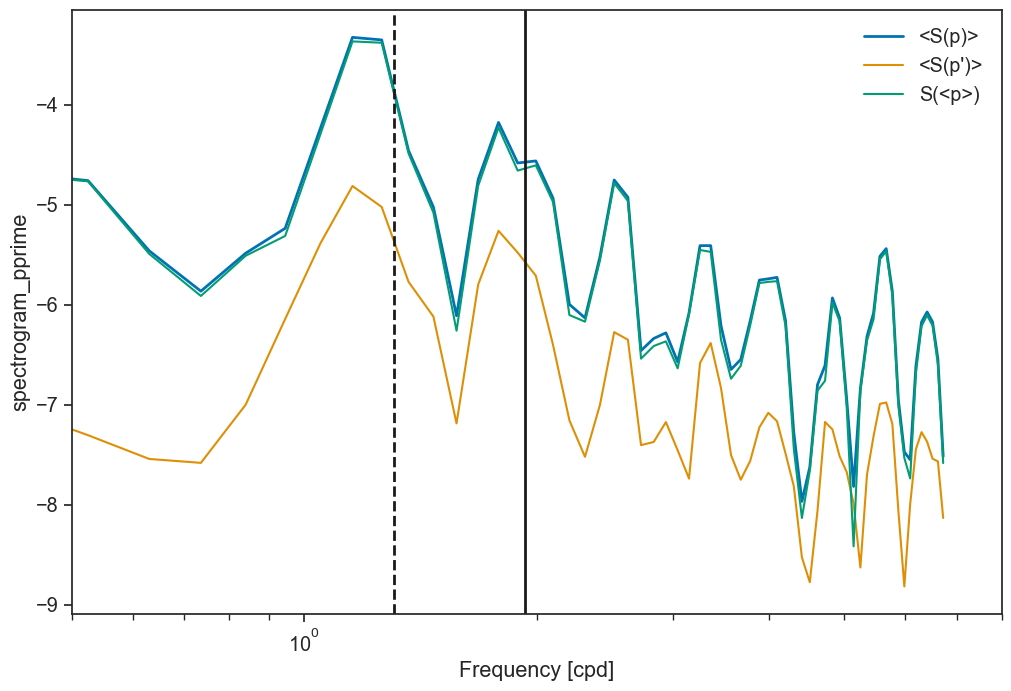

In [151]:
plt.figure(figsize=(12,8))
S_pprime.mean('z').pipe(np.log10).plot(label='<S(p)>', lw=2)
S_pprime_resid.mean('z').pipe(np.log10).plot(label="<S(p')>")
S_pprime_zmean.pipe(np.log10).plot(label=r'S(<p>)')
# plt.ylim(-1,2)
plt.xlim(5e-1,8e0)
plt.xscale('log')

latmean = 40.7

m2freq = 24/(12+25/60)
plt.axvline(m2freq, lw=2, color='k')
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='k', ls='dashed')
# plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='k')
# plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='k')

plt.xlabel('Frequency [cpd]')
plt.legend()

### Compute cgx, cgz, and omega

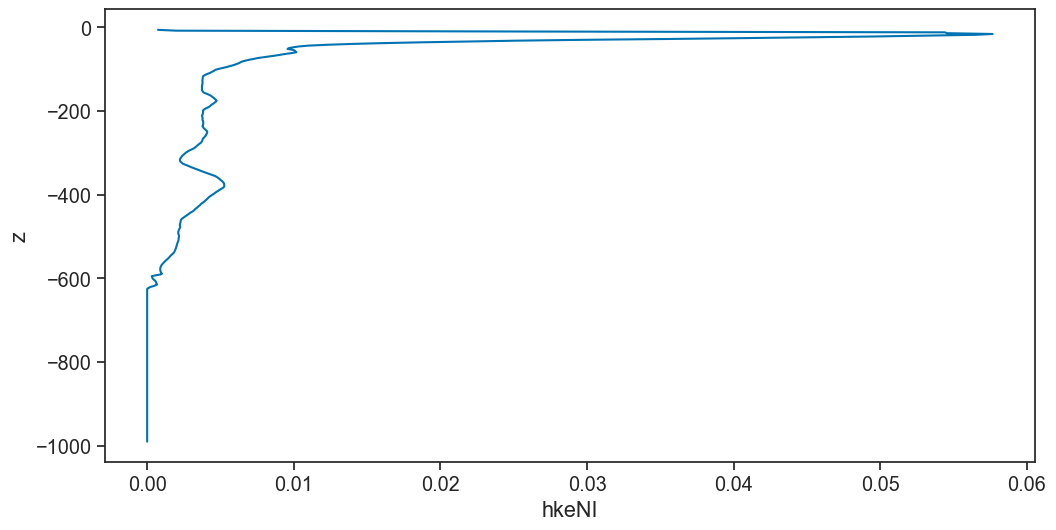

In [201]:
raw.hkeNI.mean('time').plot(y='z')

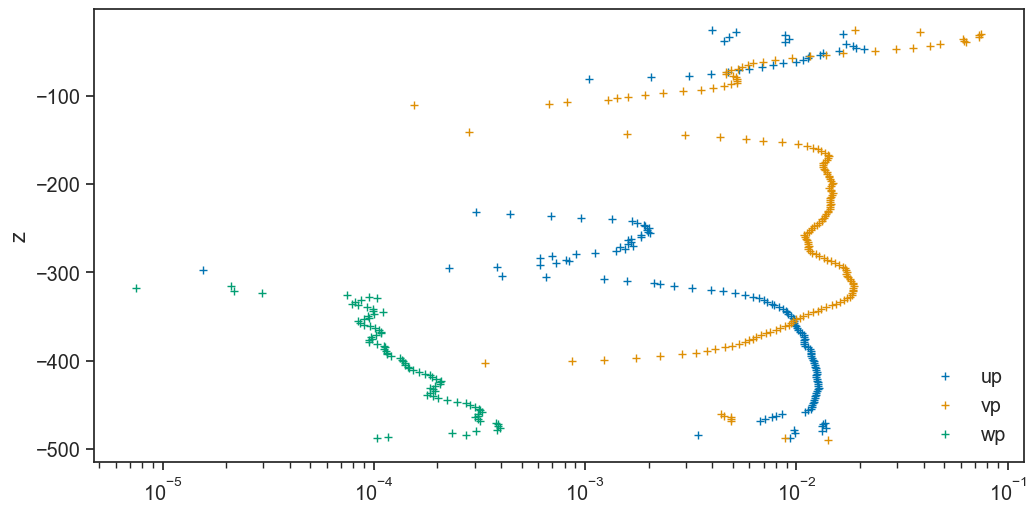

In [551]:
# raw['hkeNI'] = raw.hkeNI*(1025)
((uprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot(y='z', label='up', marker='+', lw=0)
((vprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot(y='z', label='vp', marker='+', lw=0)
((wprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot(y='z', label='wp', marker='+', lw=0)
plt.xscale('log')
# plt.xlim(1e-5,1e-1)
plt.legend()

In [426]:
((uprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot.hist(label=r"cg$_x$")
((vprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot.hist(alpha=0.4,label=r"cg$_y$")
((raw.w_fit*prime0)/raw.hkeNI.mean('time')).mean('time').pipe(lambda x: x*1000).plot.hist(alpha=0.4,label=r"100x cg$_z$")
# plt.xscale('log')
plt.xlim(-0.06,0.06)
plt.legend()
plt.xlabel('Group speed c$_g$ [m/s]')

plt.savefig('../figures/group_speed.pdf')

ValueError: 'time' not found in array dimensions ('z', 'dtime')

In [555]:
cgz.max(),cgx.max()

(<xarray.DataArray ()>
 array(0.00039791), <xarray.DataArray ()>
 array(0.02101923))

In [563]:
cgx = ((uprime*prime0)/raw.hkeNI.mean('time')).mean('time')
cgz = ((raw.w_fit*prime0)/raw.hkeNI.mean('time')).mean('time')
r_cg = cgz/cgx

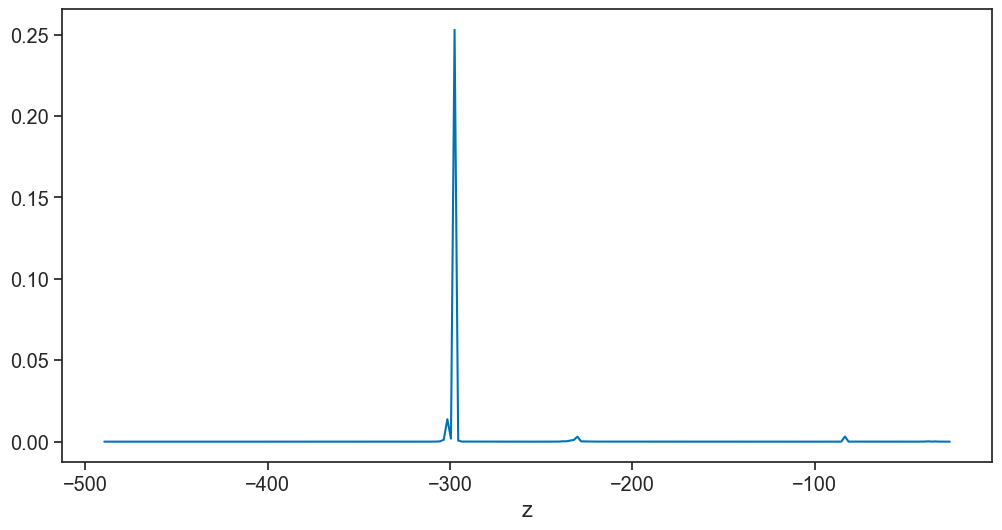

In [564]:
r_cg.pipe(np.square).plot()

In [565]:
f = gsw.f(40.7)

In [566]:
raw['n2'] = -9.81*raw.rho0.differentiate('z')/1025

In [567]:
omega = (raw.n2.mean('time')*r_cg**2 + gsw.f(40.7)**2).pipe(np.sqrt).pipe(lambda x: x/f)

In [568]:
omega.median()

<xarray.DataArray ()>
array(1.00483445)

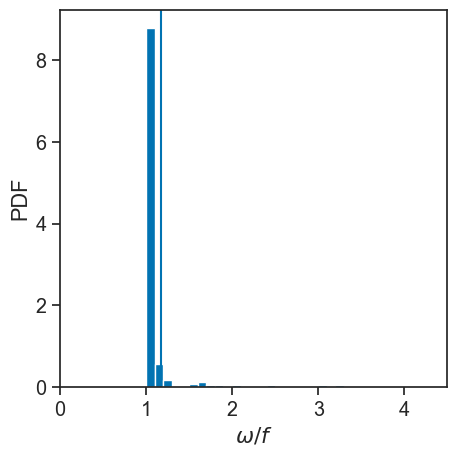

In [569]:
plt.figure(figsize=(5,5))
omega.plot.hist(range=(0,5), bins=50, density=True);
plt.axvline(1.18)
plt.xlabel(r'$\omega/f$')
plt.ylabel(r'PDF')
plt.title('')
plt.xlim(0,4.5);

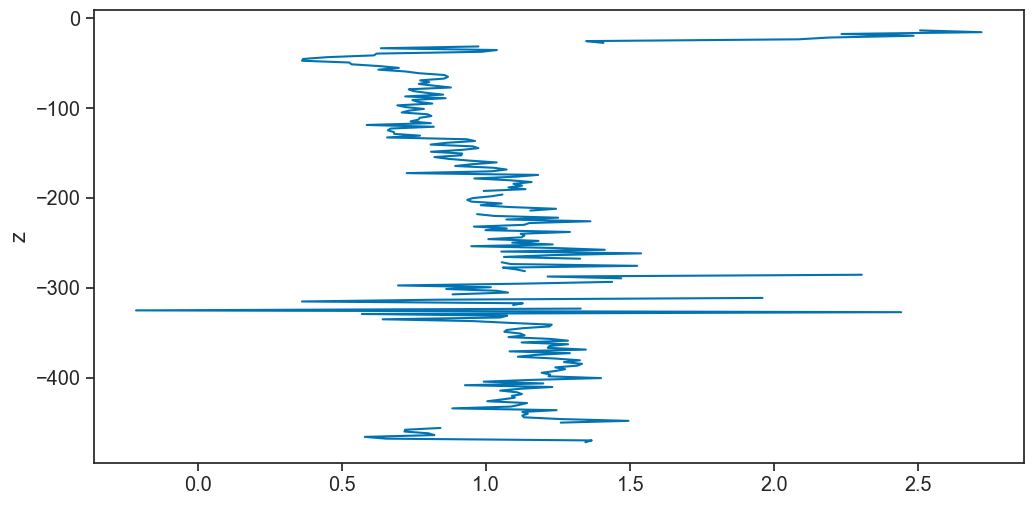

In [570]:
(raw.hkeNI/raw.ape).where(np.isfinite(raw.hkeNI/raw.ape)).mean('time').pipe(np.log10).plot(y='z')

In [571]:
r_e = (raw.hkeNI/raw.ape).where(np.isfinite(raw.hkeNI/raw.ape)).mean('time')

In [572]:
omega.median()

<xarray.DataArray ()>
array(1.00483445)

In [573]:
omega_e = (-f**2*(1+r_e)/(1-r_e)).pipe(np.sqrt).pipe(lambda x: x/f)

In [574]:
omega_e.median()

<xarray.DataArray ()>
array(1.08888074)

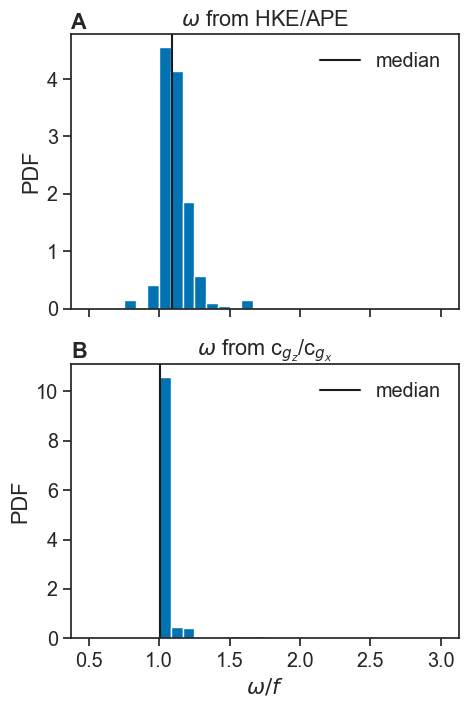

In [575]:
fig, ax = plt.subplots(2,1,figsize=(5,8), sharex=True)

omega_e.plot.hist(
    bins=30,ax=ax[0],range=(0.5,3), density=True)
ax[0].set_title('')
ax[0].set_title(r'$\omega$ from HKE/APE', loc='center')
ax[0].set_ylabel(r'PDF')
ax[0].axvline(omega_e.median(), color='k', label='median')
ax[0].legend()

omega.plot.hist(
    range=(0.5,3), bins=30, density=True,ax=ax[1]);
ax[1].set_title('')
ax[1].set_title(r'$\omega$ from c$_{g_z}$/c$_{g_x}$', loc='center')
ax[1].set_xlabel(r'$\omega/f$')
ax[1].set_ylabel(r'PDF')
ax[1].axvline(omega.median(), color='k', label='median')
ax[1].legend()

alphabet(ax)

plt.savefig('../figures/omegas_for_eric.pdf',dpi=500)

In [576]:
phase = xr.open_dataset('phase_data.nc')
phase.coords['z'] = -phase.z

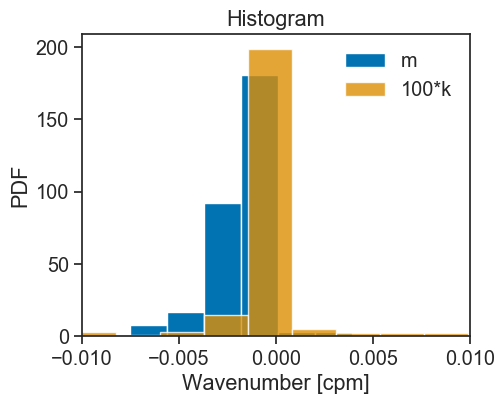

In [581]:
plt.figure(figsize=(5,4))
phase.hke_kz.mean('time').plot.hist(bins=50, label='m');
(-phase.hke_kz.mean('time')*r_cg).pipe(lambda x: x*100).plot.hist(bins=50,alpha=0.8, label='100*k')
plt.xlim(-1e-2,1e-2)
plt.xlabel('Wavenumber [cpm]')
plt.ylabel('PDF')
plt.legend()

plt.savefig('../figures/k_for_eric.pdf',dpi=500)

### HKE/APE plots

In [557]:
test['new_n2'] = (('z','backup_time'), test.n2)

In [567]:
test['eta_ape'] = (test.fit**2*test.new_n2/2).transpose()

In [576]:
test['new_hkeNI'] = (('z','backup_time'), raw.hkeNI)

In [580]:
test['eratio'] = test.new_hkeNI/test.eta_ape/rho0

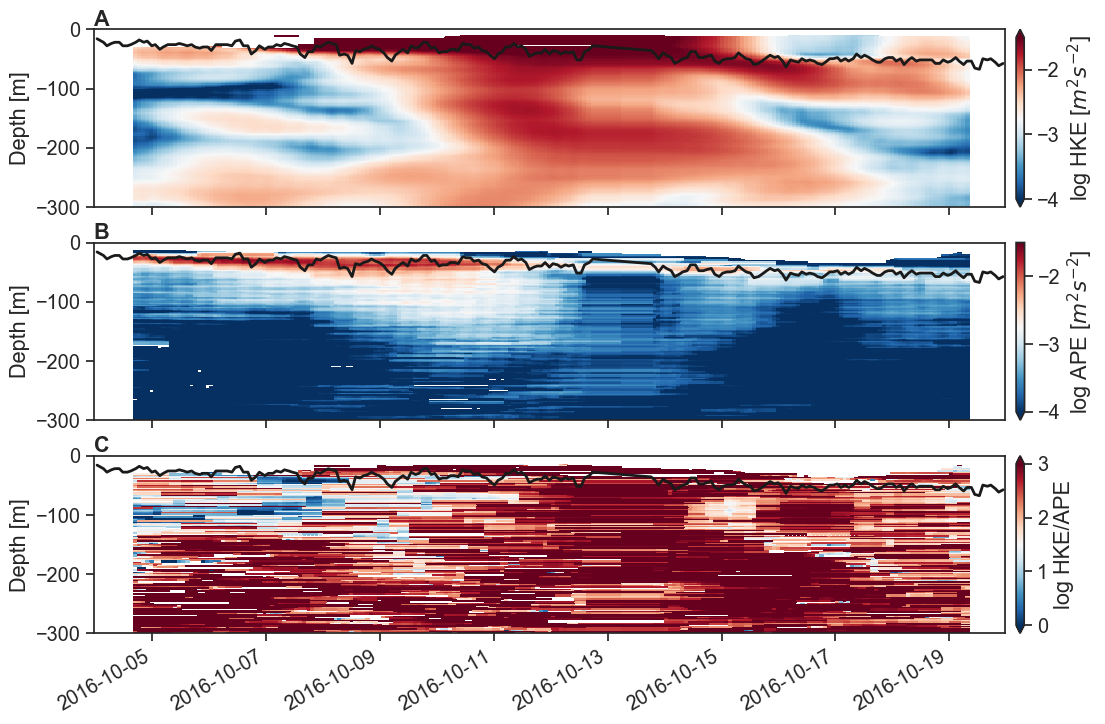

In [592]:
rho0 = raw.rho0.mean()
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(3,1, sharex=True, figsize=(14,8))

raw.hkeNI.rolling(time=19, center=True).mean().pipe(lambda x: x/rho0).pipe(np.log10).plot(
    vmin=-4, vmax=-1.5, cmap='RdBu_r', ax=ax[0], rasterized=True,
                             cbar_kwargs={'pad':0.01,'label':'log HKE [$m^2 s^{-2}$]'})
raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-300,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')


test.eta_ape.rolling(backup_time=19, center=True).mean().pipe(np.log10).plot(
    vmin=-4, vmax=-1.5, cmap='RdBu_r', ax=ax[1], rasterized=True,
                           cbar_kwargs={'pad':0.01,'label':'log APE [$m^2 s^{-2}$]'})
raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-300,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

test.eratio.rolling(backup_time=19, center=True).mean().pipe(np.log10).plot(vmin=0, vmax=3, cmap='RdBu_r',ax=ax[2], rasterized=True,
                               cbar_kwargs={'pad':0.01,'label':'log HKE/APE'})
raw.mld.plot(color='k', lw=2, ax=ax[2])
ax[2].set_ylim(-300,0)
ax[2].set_xlabel(None)
ax[2].set_ylabel('Depth [m]')

alphabet(ax)

plt.savefig('../figures/hke_ape.pdf')

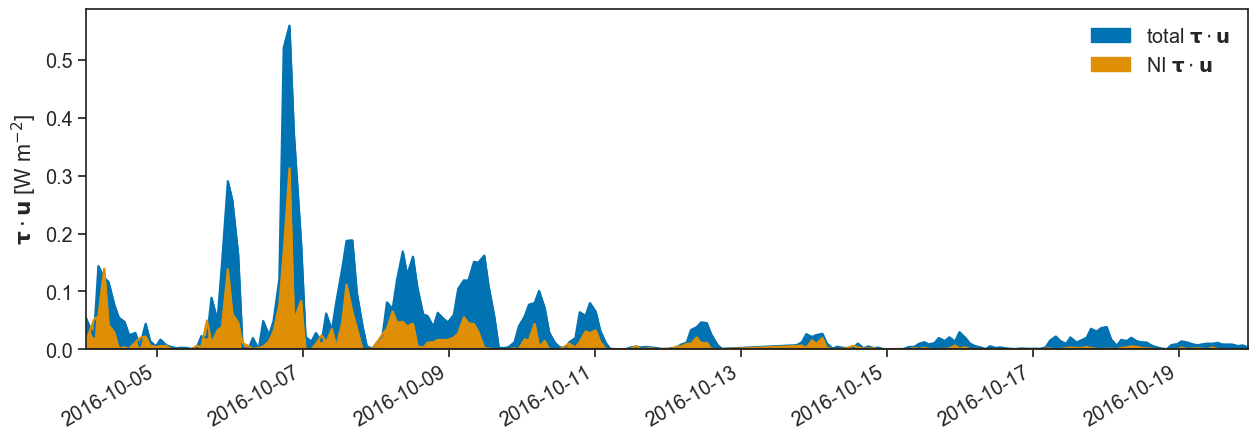

(array([ 33., 154.,  21.,   2.,   2.,   2.,   0.,   0.,   0.,   1.]),
 array([-0.035522  , -0.00067803,  0.03416594,  0.06900991,  0.10385388,
         0.13869784,  0.17354181,  0.20838578,  0.24322975,  0.27807372,
         0.31291769]),
 <a list of 10 Patch objects>)

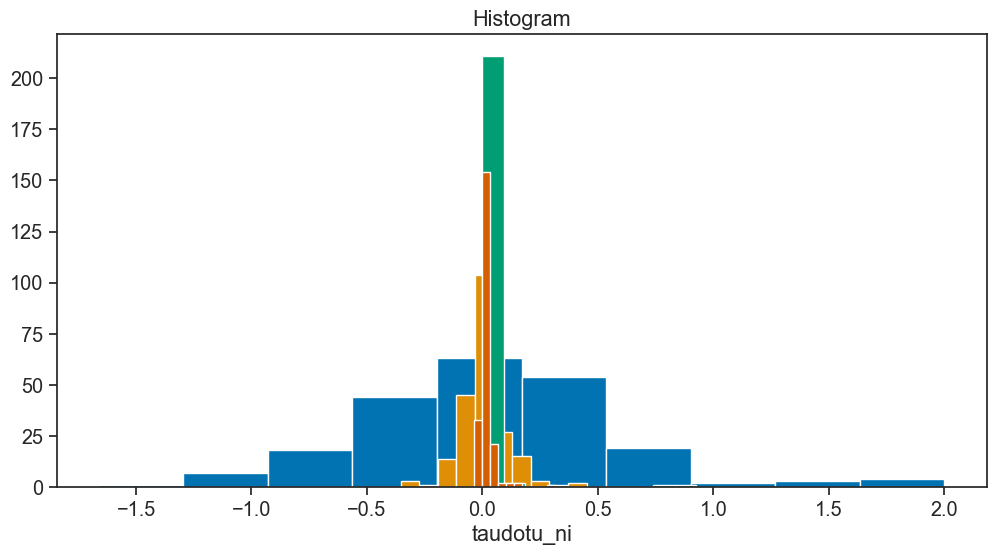

In [601]:
raw.dhke_py.plot.hist()
raw.dape_py.plot.hist()
raw.eps_py.pipe(lambda x: x*10).plot.hist()
raw.taudotu_ni.plot.hist()

In [608]:
raw['hkeNI'] = raw['hkeNI']/1025
raw['hkeTOT'] = raw['hkeTOT']/1025

In [609]:
# just to check takes simple averages
zmin = -300
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)

raw['eps_ml'] = raw.eps.where(ml_mask).fillna(0).mean(dim='z')
raw['eps_py'] = raw.eps.where(py_mask).fillna(0).mean(dim='z')

raw['ape_ml'] = raw.ape.fillna(0).rolling(time=18, center=True).mean().where(ml_mask).mean(dim='z')
raw['ape_py'] = raw.ape.fillna(0).rolling(time=18, center=True).mean().where(py_mask).mean(dim='z')

raw['hke_ml_ni'] = raw.hkeNI.fillna(0).rolling(time=18, center=True).mean().where(ml_mask).mean(dim='z')
raw['hke_py_ni'] = raw.hkeNI.fillna(0).rolling(time=18, center=True).mean().where(py_mask).mean(dim='z')
raw['hke_ml'] = raw.hkeTOT.fillna(0).rolling(time=18, center=True).mean().where(ml_mask).mean(dim='z')
raw['hke_py'] = raw.hkeTOT.fillna(0).rolling(time=18, center=True).mean().where(py_mask).mean(dim='z')

raw['dape_ml'] = raw['ape_ml'].differentiate('time',datetime_unit='s')
raw['dape_py'] = raw['ape_py'].differentiate('time',datetime_unit='s')

raw['dhke_ml'] = raw['hke_ml'].differentiate('time',datetime_unit='s')
raw['dhke_ml_ni'] = raw['hke_ml_ni'].differentiate('time',datetime_unit='s')
raw['dhke_py'] = raw['hke_py'].differentiate('time',datetime_unit='s')
raw['dhke_py_ni'] = raw['hke_py_ni'].differentiate('time',datetime_unit='s')

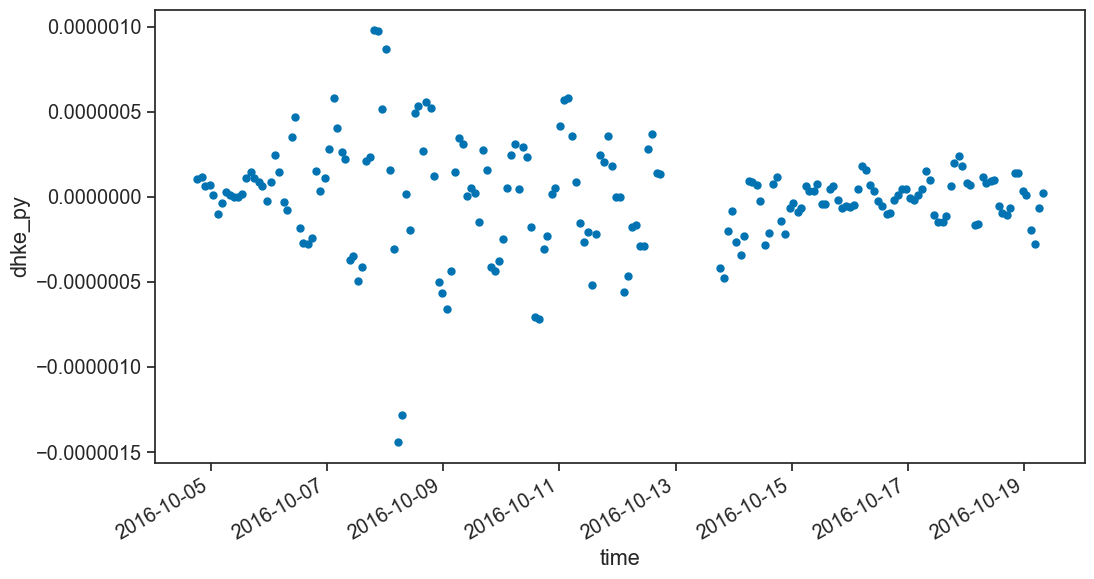

In [610]:
raw.dhke_py.plot(lw=0, marker='.', label='dHKE', ms=10)

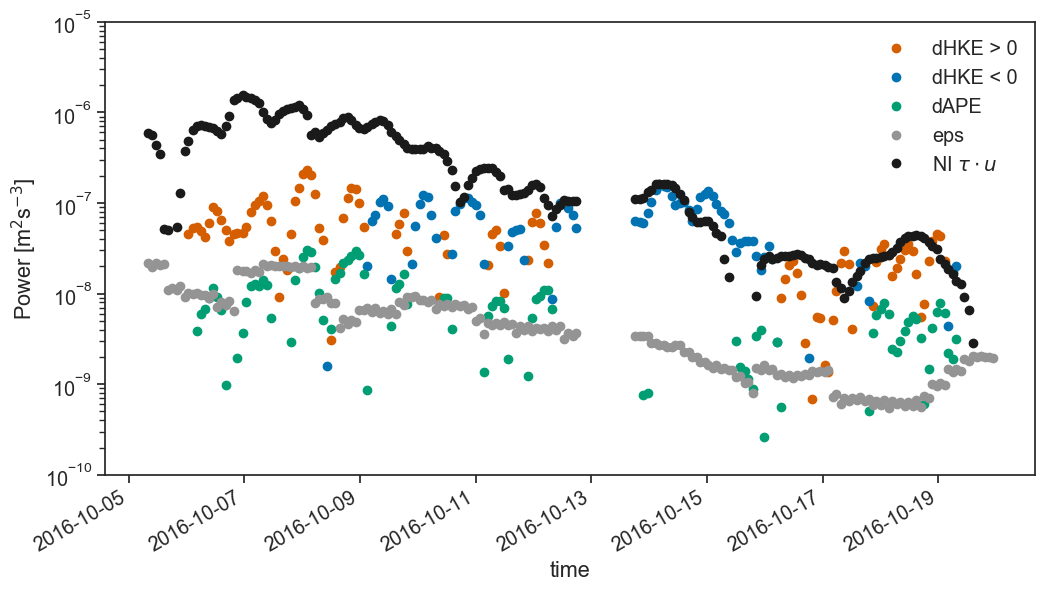

In [671]:
rho0 = 1025
raw.dhke_py.rolling(time=19).mean().plot(lw=0, marker='.', label='dHKE > 0', ms=12, color='r')
raw.dhke_py.rolling(time=19).mean().pipe(lambda x: x*-1).plot(lw=0, marker='.', label='dHKE < 0', ms=12, color='b')

raw.dape_py.rolling(time=19).mean().plot(lw=0, marker='.', label='dAPE', ms=12, color='g')
raw.eps_py.rolling(time=19).mean().plot(lw=0, marker='.', label='eps', ms=12, color='C7')

raw.taudotu_ni.pipe(lambda x: x/rho0/np.abs(raw.mld)).rolling(time=19).mean().plot(label=r'NI $\tau \cdot u$',lw=0, marker='.', ms=12, color='k')
# raw.taudotu_ni.pipe(lambda x: -x/rho0/np.abs(raw.mld)).plot(label=r'NI $\tau \cdot u$',lw=0, marker='+', color='r', ms=10)

plt.yscale('log')
plt.ylabel(r'Power [m$^2$s$^{-3}$]')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.legend(loc=0)
plt.ylim(1e-10,1e-5)

plt.savefig('../figures/power_terms.pdf')

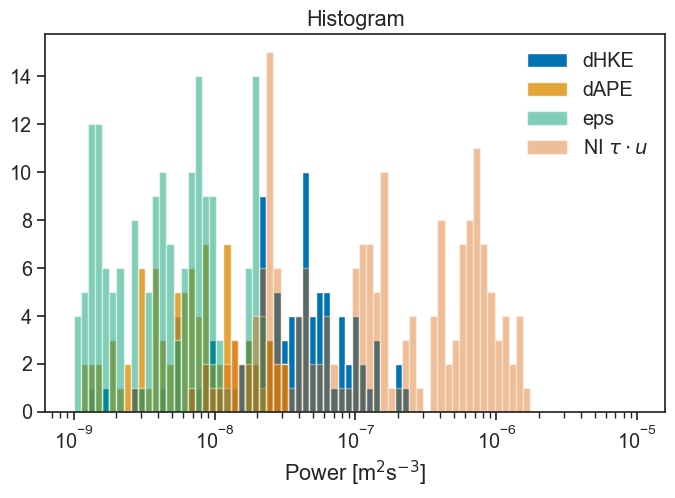

In [650]:
bins=np.logspace(-9,-5,80)

plt.figure(figsize=(8,5))
rho0 = 1025
raw.dhke_py.rolling(time=19).mean().plot.hist(label='dHKE', bins=bins)
raw.dape_py.rolling(time=19).mean().plot.hist(label='dAPE', bins=bins, alpha=0.8)
raw.eps_py.rolling(time=19).mean().plot.hist(label='eps', bins=bins, alpha=0.5)
raw.taudotu_ni.pipe(lambda x: x/rho0/np.abs(raw.mld)).rolling(time=19).mean().plot.hist(label=r'NI $\tau \cdot u$', alpha=0.4, bins=bins)


plt.xscale('log')
plt.legend(loc=0)

plt.xlabel(r'Power [m$^2$s$^{-3}$]')

plt.savefig('../figures/power_terms.pdf')